# 📦 1. Import Libraries & Configure GPU

## Imports

In [1]:
import os, shutil, time, zipfile, spacy
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # type: ignore
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM  # type: ignore
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer  # type: ignore

2025-05-27 22:58:35.921480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748375915.936239   10900 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748375915.940600   10900 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748375915.951716   10900 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748375915.951771   10900 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748375915.951773   10900 computation_placer.cc:177] computation placer alr

## Check for GPU

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
if physical_devices:
    print(f"✅ GPU detected: {physical_devices[0].name}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("⚠️ No GPU found, using CPU")

✅ GPU detected: /physical_device:GPU:0


# ⚙️ 2. Download & Set Global Configuration

## Extact Datset

In [3]:
folder_name = "dev-acad-nlp"
zip_file_name = folder_name + ".zip"
data_dir = "data"

# Ensure 'data' directory exists
os.makedirs(data_dir, exist_ok=True)

if os.path.isdir(folder_name):
    # Zip the folder
    shutil.make_archive(folder_name, "zip", folder_name)

    # Remove the original folder
    shutil.rmtree(folder_name)

    # Move the zip to the data folder
    shutil.move(zip_file_name, os.path.join(data_dir, zip_file_name))
    print(f"'{folder_name}' zipped and moved to '{data_dir}'")

else:
    # If folder doesn't exist, try to extract it
    if os.path.exists(zip_file_name):
        with zipfile.ZipFile(zip_file_name, "r") as zip_ref:
            zip_ref.extractall(data_dir)
        print(f"'{zip_file_name}' extracted to '{data_dir}'")
    else:
        print(f"Neither '{folder_name}' directory nor '{zip_file_name}' found.")

'dev-acad-nlp.zip' extracted to 'data'


## Model & preprocessing settings

In [4]:
MAX_NUM_WORDS = 45000
MAX_SEQUENCE_LENGTH = 256
EMBEDDING_DIM = 300
BATCH_SIZE = 64
EPOCHS = 10

## Paths

In [5]:
train_path = "data/train/train/"
test_path = "data/test/test"
labels_csv_path = "data/labels_train.csv"
submission_sample_path = "submission.csv"

# 🗂 3. Load and Visualize Label Distribution

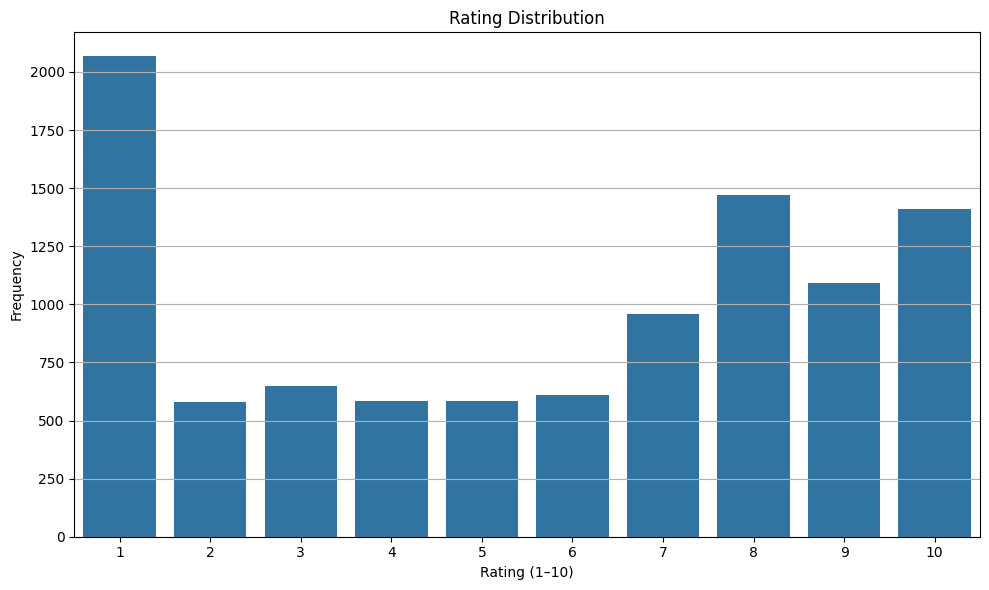

In [6]:
labels_df = pd.read_csv(labels_csv_path)
labels_dict = dict(zip(labels_df["ReviewID"], labels_df["Rating"]))

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(
    x=labels_df["Rating"].value_counts().sort_index().index,
    y=labels_df["Rating"].value_counts().sort_index().values,
)
plt.title("Rating Distribution")
plt.xlabel("Rating (1–10)")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# 📥 4. Load and Preprocess Text Data

## Load training data

In [7]:
train_files = sorted(Path(train_path).glob("*.txt"))
train_ids = [f.stem for f in train_files]
train_texts = [f.read_text(encoding="latin-1") for f in train_files]
train_labels = [labels_dict[i] - 1 for i in train_ids]  # 1–10 → 0–9

test_files = sorted(Path(test_path).glob("*.txt"))
test_ids = [f.stem for f in test_files]
test_texts = [f.read_text(encoding="latin-1") for f in test_files]

## Clean Text

In [8]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


def clean_text(text: str) -> str:
    doc = nlp(text)
    tokens = [tok.lemma_.lower() for tok in doc if tok.is_alpha and not tok.is_stop]
    return " ".join(tokens)

## Apply to all datasets

In [9]:
train_texts = [clean_text(t) for t in train_texts]
test_texts = [clean_text(t) for t in test_texts]

# 🧪 5. Split Data for Validation

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    train_texts, train_labels, test_size=0.1, random_state=42
)

# ✂️ 6. Tokenize and Pad Sequences

In [11]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_texts)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

# 🧠 7. Build LSTM Model

In [12]:
model = Sequential(
    [
        Embedding(MAX_NUM_WORDS, EMBEDDING_DIM),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dropout(0.5),
        Dense(32, activation="relu"),
        Dropout(0.3),
        Dense(10, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

I0000 00:00:1748376199.688999   10900 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14215 MB memory:  -> device: 0, name: Quadro RTX 5000 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


# 🚀 8. Train the Model with Callbacks

In [13]:
early_stop = EarlyStopping(monitor="val_loss", patience=2)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1)

with tf.device("/GPU:0" if physical_devices else "/CPU:0"):
    model.fit(
        X_train_pad,
        np.array(y_train),
        validation_data=(X_val_pad, np.array(y_val)),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop, reduce_lr],
    )

Epoch 1/10


I0000 00:00:1748376203.224881   11901 cuda_dnn.cc:529] Loaded cuDNN version 90300


141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.1785 - loss: 2.2206 - val_accuracy: 0.3410 - val_loss: 1.8388 - learning_rate: 0.0010
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.3546 - loss: 1.7509 - val_accuracy: 0.3440 - val_loss: 1.7487 - learning_rate: 0.0010
Epoch 3/10
 80/141 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.4079 - loss: 1.4993
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.4126 - loss: 1.4895 - val_accuracy: 0.3440 - val_loss: 1.7533 - learning_rate: 0.0010
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4964 - loss: 1.2573
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.4964 - loss: 1.2572 - val_accuracy: 0.3330 - val_loss: 1.8714 - learning_rate: 5.0000e-04


# 📊 9. Evaluate on Validation Set

In [14]:
start = time.time()

val_predictions = model.predict(X_val_pad)
val_predicted_classes = np.argmax(val_predictions, axis=1)
val_predicted_ratings = val_predicted_classes + 1
val_true_ratings = np.array(y_val) + 1

val_accuracy = accuracy_score(val_true_ratings, val_predicted_ratings)
val_mae = mean_absolute_error(val_true_ratings, val_predicted_ratings)

end = time.time()

print(f"🕒 Predictions on validation set completed in {end - start:.3f} seconds")
print(f"🎯 Accuracy on validation set: {val_accuracy * 100:.1f} %")
print(f"📉 MAE on validation set: {val_mae:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
🕒 Predictions on validation set completed in 1.263 seconds
🎯 Accuracy on validation set: 33.3 %
📉 MAE on validation set: 1.453


# 📤 10. Predict on Test Set and Save Submission

In [15]:
test_predictions = model.predict(X_test_pad)
test_predicted_classes = np.argmax(test_predictions, axis=1) + 1

submission = pd.DataFrame({"ReviewId": test_ids, "Rating": test_predicted_classes})
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv file has been saved.")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
✅ submission.csv file has been saved.
